In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import model_selection
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics

Ucitani su podaci preko excell tabele koja je skinuta sa "https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets" web stranice.

In [30]:
data = pd.read_csv('sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [31]:
data.head(2)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


Kao sto mozemo da primetimo, podaci icitani na ovaj nacin nemaju adekvatno numerisane kolone. Kako je nemoguce dodati novu kolonu zbog limitacije excela (moze da ima ucitano 2^20 tj. 1048576 redova), preimenovan je prvi red u adekvatne atribute.

In [32]:
data = data.rename(columns={'0':'Sentiment',
                     '1467810369': 'Tweet ID',
                     'Mon Apr 06 22:19:45 PDT 2009':'Date',
                     'NO_QUERY':'Query',
                     '_TheSpecialOne_':'Username',
                     "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D":'Tweet'})

In [33]:
data.head(2)

,Sentiment,Tweet ID,Date,Query,Username,Tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


Sentiment atribut oznacava da li je tvit pozitivan ili negativan. Vrednosti oznacene sa 0 odgovaraju negativnom sentimentu, 2 odgovara neutralnom sentimentu, dok 4 odgovara pozitivnom sentimentu

In [34]:
sentiments = data['Sentiment'].value_counts().keys()
sentiments

Index([4, 0], dtype='int64', name='Sentiment')

In [35]:
np.unique(sentiments)

array([0, 4], dtype=int64)

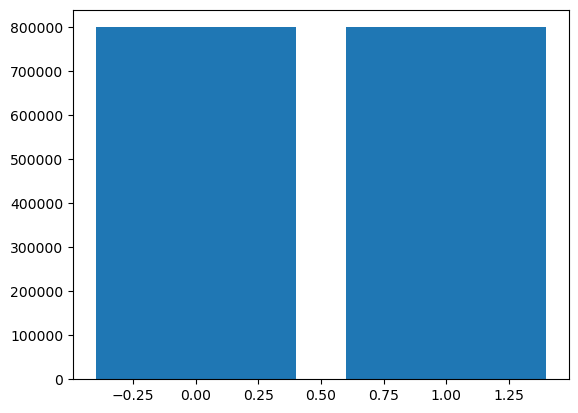

In [92]:
plt.bar(data['Sentiment'].value_counts().keys(), data['Sentiment'].value_counts().values)
plt.show()

Kao sto mozemo da primetimo, uklonjeni su svi neutralni sentimenti, sa tim na umu su remapirane ciljne vrednosti u 0 (negativan) i 1 (pozitivan)

In [37]:
def Sentiment_remap(x):
    if x == 0:
        return 0
    else:
        return 1

In [38]:
data['Sentiment'] = data['Sentiment'].apply(Sentiment_remap)

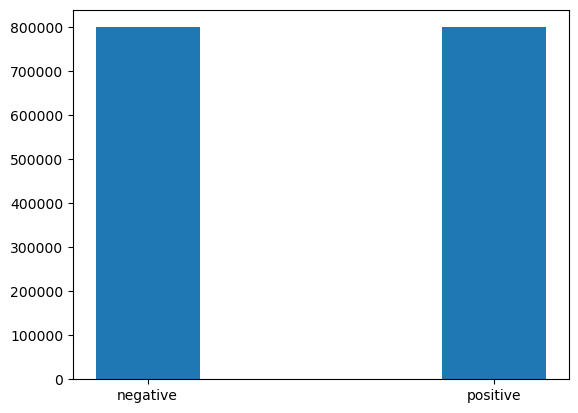

In [39]:
plt.bar(data['Sentiment'].value_counts().keys(),data['Sentiment'].value_counts().values, width = 0.3)
plt.xticks([0,1], labels=['negative', 'positive'])
plt.show()

In [48]:
data['Tweet']

0          is upset that he can't update his Facebook by ...
1          @Kenichan I dived many times for the ball. Man...
2            my whole body feels itchy and like its on fire 
3          @nationwideclass no, it's not behaving at all....
4                              @Kwesidei not the whole crew 
                                 ...                        
1599994    Just woke up. Having no school is the best fee...
1599995    TheWDB.com - Very cool to hear old Walt interv...
1599996    Are you ready for your MoJo Makeover? Ask me f...
1599997    Happy 38th Birthday to my boo of alll time!!! ...
1599998    happy #charitytuesday @theNSPCC @SparksCharity...
Name: Tweet, Length: 1599999, dtype: object

Kao sto se moze primetiti vecina tweetova su usmereni ka nekom specificnom korisniku, sto u vecini slucajeva nema uticaj na sam sentiment, shodno tome su korisnicka imena uklonjena sledecom funkcijom.

In [41]:
def username_removal(string):
    
    for i in range(string.count('@')): 
        username_begin_index = string.find('@')
        username_end_index = string[username_begin_index::].find(' ') + username_begin_index
    
        string = string.replace(string[username_begin_index:username_end_index+1],' ')
    
    return string                    

In [49]:
x = data['Tweet']
y = data['Sentiment']

In [55]:
num_of_chars = 0
for i in range(x.shape[0]):
    if not bool(x[i].find('@')):
        num_of_chars+=1
        #print('@ is at: ', i)
print("number of @ found is: ", num_of_chars)

number of @ found is:  698078


Kao sto mozemo da vidimo preko 40% tweetova sadrzi referencu ka nekom korisnickom nalogu

In [56]:
x = x.apply(username_removal)

In [57]:
num_of_chars = 0
for i in range(x.shape[0]):
    if not bool(x[i].find('@')):
        num_of_chars+=1
        #print('@ is at: ', i)
print("number of @ found is: ", num_of_chars)

number of @ found is:  0


Kao sto mozemo da primetimo svi "@" su uklonjeni iz tweetova

In [58]:
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (1599999,)
y shape:  (1599999,)


In [61]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,train_size=0.06,test_size=0.01, stratify=y, random_state=7)

In [60]:
print(x_train.shape)
print(x_test.shape)

(15999,)
(16000,)


Napravljena je vektorska reprezentacija teksta metodom Vreca reci

In [62]:
tweet_count_vectorizer = feature_extraction.text.CountVectorizer(min_df=2)

In [63]:
tweet_count_vectorizer.fit(x_train)

CountVectorizer(min_df=2)

In [64]:
feature_names = tweet_count_vectorizer.get_feature_names_out()

In [65]:
len(feature_names)

21564

In [66]:
x_train_vectorized = tweet_count_vectorizer.transform(x_train)
x_test_vectorized = tweet_count_vectorizer.transform(x_test)

# Model 1 - logisticka regresija

In [67]:
model1 = linear_model.LogisticRegression()

In [68]:
model1.fit(x_train_vectorized,y_train)

D:\Users\mata2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Tacnost modela na trening i test skupu

In [69]:
model1_skor_train = model1.score(x_train_vectorized, y_train)
model1_skor_test = model1.score(x_test_vectorized, y_test)

In [70]:
print("skor na podacima za treniranje: ", model1_skor_train)
print('skor na podacima za testiranje: ', model1_skor_test)

skor na podacima za treniranje:  0.831664913176179
skor na podacima za testiranje:  0.7760625


### Matrica konfuzije - logisticka regresija

In [71]:
y_predicted_lr = model1.predict(x_test_vectorized)

In [72]:
matrica_konfuzije_lr = metrics.confusion_matrix(y_test, y_predicted_lr)
matrica_konfuzije_lr

array([[6091, 1909],
       [1674, 6326]], dtype=int64)

In [87]:
metrics.f1_score(y_test, y_predicted_lr)

0.7793039728980597

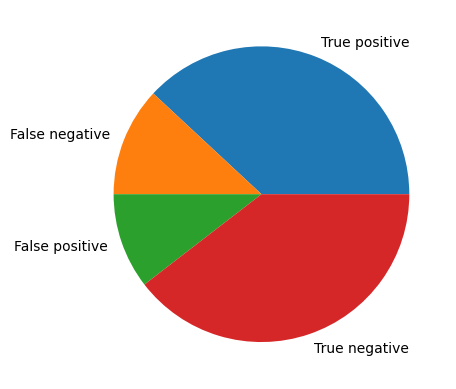

In [93]:
plt.pie(matrica_konfuzije_lr.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 2 - linearni SVM

In [74]:
model2 = svm.LinearSVC()

In [75]:
model2.fit(x_train_vectorized, y_train)

D:\Users\mata2\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [76]:
model2_skor_train = model2.score(x_train_vectorized, y_train)
model2_skor_test = model2.score(x_test_vectorized, y_test)

In [77]:
print("skor na podacima za treniranje: ", model2_skor_train)
print('skor na podacima za testiranje: ', model2_skor_test)

skor na podacima za treniranje:  0.8619256450588026
skor na podacima za testiranje:  0.7549375


In [78]:
y_pred_svm = model2.predict(x_test_vectorized)
matrica_konfuzije_svm = metrics.confusion_matrix(y_test, y_pred_svm)
matrica_konfuzije_svm

array([[5926, 2074],
       [1847, 6153]], dtype=int64)

### Matrica konfuzije - linearni SVM

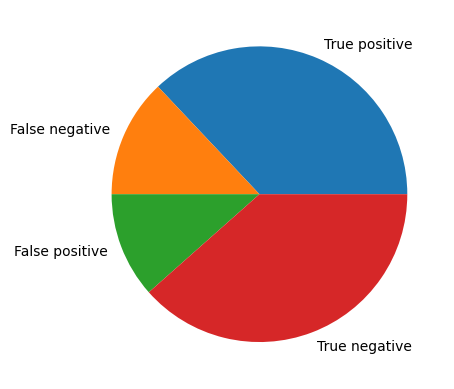

In [94]:
plt.pie(matrica_konfuzije_svm.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()

# MODEL 3 - k najblizih suseda

In [80]:
model3 = neighbors.KNeighborsClassifier(n_neighbors=4)

In [81]:
model3.fit(x_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=4)

In [82]:
model3_skor_train = model3.score(x_train_vectorized, y_train)
model3_skor_test = model3.score(x_test_vectorized, y_test)

In [83]:
print("skor na podacima za treniranje: ", model3_skor_train)
print('skor na podacima za testiranje: ', model3_skor_test)

skor na podacima za treniranje:  0.7970812195960375
skor na podacima za testiranje:  0.67475


In [89]:
y_pred_kneigh = model3.predict(x_test_vectorized)
matrica_konfuzije_kneigh = metrics.confusion_matrix(y_test, y_pred_kneigh)
matrica_konfuzije_kneigh

array([[5478, 2522],
       [2682, 5318]], dtype=int64)

### Matrica konfuzije - k najblizih suseda

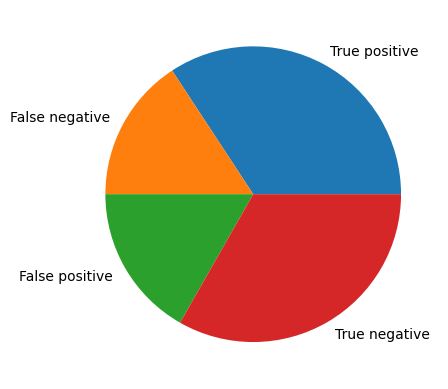

In [95]:
plt.pie(matrica_konfuzije_kneigh.ravel(), labels=['True positive', 'False negative','False positive', 'True negative'])
plt.show()